/home/haoxiang/sam3/sam3/model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
INFO 2026-02-04 09:28:08,149 626489 sam3_video_predictor.py: 300: using the following GPU IDs: [0, 1, 2, 3]
INFO 2026-02-04 09:28:08,152 626489 sam3_video_predictor.py: 316: 


	*** START loading model on all ranks ***


INFO 2026-02-04 09:28:08,153 626489 sam3_video_predictor.py: 318: loading model on rank=0 with world_size=4 -- this could take a while ...
INFO 2026-02-04 09:28:54,311 626489 sam3_video_base.py: 125: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2026-02-04 09:29:15,383 626489 sam3_video_predictor.py: 320: loading model on rank=0 with world_size=4 -- DONE locally
INFO 2026-02-04 09:29:15,386 626489 sam3_video_predictor.py: 377: spawning 3 worker proc

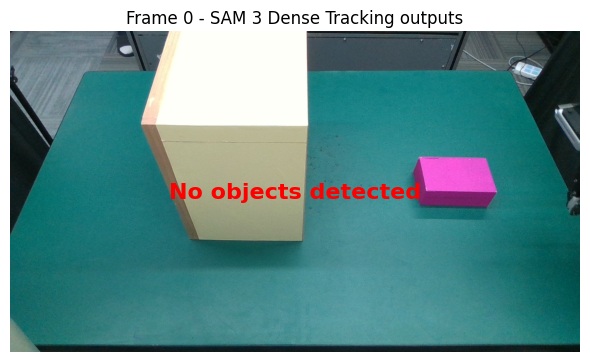

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4,5,6"
import sam3
import torch
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")
# video_path = f"{sam3_root}/assets/videos/camera0_rgb.mp4"
# video_path = "/data/haoxiang/acp/flip_v3/scene_0001/cam_104122060902/color"
video_path = "/data/haoxiang/data/FLIPPING_v3/train/scene_0001/cam_104122060902/color"

# use all available GPUs on the machine
gpus_to_use = range(torch.cuda.device_count())

from sam3.model_builder import build_sam3_video_predictor

predictor = build_sam3_video_predictor(checkpoint_path="/data/haoxiang/sam3/models/facebook/sam3/sam3.pt",gpus_to_use=gpus_to_use)

from sam3.visualization_utils import (
    load_frame,
    prepare_masks_for_visualization,
    visualize_formatted_frame_output,
)

# font size for axes titles
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["figure.titlesize"] = 12

# 工具函数

def propagate_in_video(predictor, session_id):
    # we will just propagate from frame 0 to the end of the video
    outputs_per_frame = {}
    for response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
        )
    ):
        outputs_per_frame[response["frame_index"]] = response["outputs"]

    return outputs_per_frame


def abs_to_rel_coords(coords, IMG_WIDTH, IMG_HEIGHT, coord_type="point"):
    """Convert absolute coordinates to relative coordinates (0-1 range)

    Args:
        coords: List of coordinates
        coord_type: 'point' for [x, y] or 'box' for [x, y, w, h]
    """
    if coord_type == "point":
        return [[x / IMG_WIDTH, y / IMG_HEIGHT] for x, y in coords]
    elif coord_type == "box":
        return [
            [x / IMG_WIDTH, y / IMG_HEIGHT, w / IMG_WIDTH, h / IMG_HEIGHT]
            for x, y, w, h in coords
        ]
    else:
        raise ValueError(f"Unknown coord_type: {coord_type}")

# load "video_frames_for_vis" for visualization purposes (they are not used by the model)
if isinstance(video_path, str) and video_path.endswith(".mp4"):
    cap = cv2.VideoCapture(video_path)
    video_frames_for_vis = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        video_frames_for_vis.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
else:
    video_frames_for_vis = glob.glob(os.path.join(video_path, "*.png"))
    try:
        # integer sort instead of string sort (so that e.g. "2.jpg" is before "11.jpg")
        video_frames_for_vis.sort(
            key=lambda p: int(os.path.splitext(os.path.basename(p))[0])
        )
    except ValueError:
        # fallback to lexicographic sort if the format is not "<frame_index>.jpg"
        print(
            f'frame names are not in "<frame_index>.png" format: {video_frames_for_vis[:5]=}, '
            f"falling back to lexicographic sort."
        )
        video_frames_for_vis.sort()

response = predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_path,
    )
)
session_id = response["session_id"]

# # note: in case you already ran one text prompt and now want to switch to another text prompt
# # it's required to reset the session first (otherwise the results would be wrong)
# _ = predictor.handle_request(
#     request=dict(
#         type="reset_session",
#         session_id=session_id,
#     )
# )

# 开始使用prompt

prompt_text_str = "robot and cable"
# prompt_text_str = "robot arm with black cable"
# prompt_text_str = "black end-effector"
frame_idx = 0  # add a text prompt on frame 0

# 这里idx需要从0开始，不然之前的不识别

response = predictor.handle_request(
    request=dict(
        type="add_prompt", # 既然是add_prompt，这里其实是对这个predictor进行操作，request中内容会存储在class中
        session_id=session_id,
        frame_index=frame_idx,
        text=prompt_text_str,
    )
)
out = response["outputs"]

# 先画一张出来测试一下

plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    video_frames_for_vis,
    outputs_list=[prepare_masks_for_visualization({frame_idx: out})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
)

propagate_in_video:   0%|          | 0/260 [00:00<?, ?it/s]

propagate_in_video: 0it [00:00, ?it/s]

260


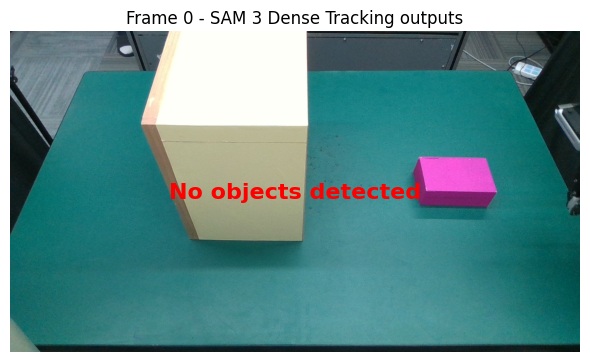

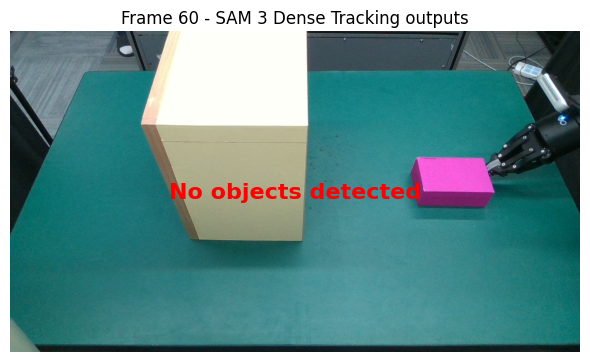

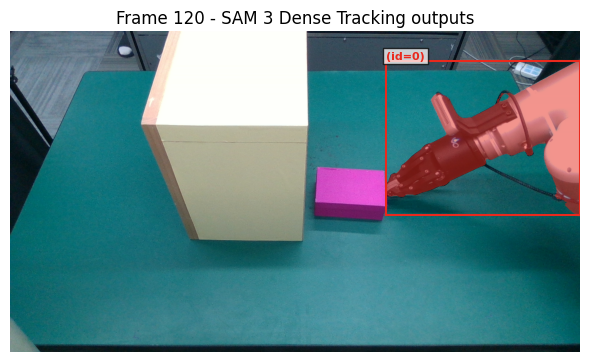

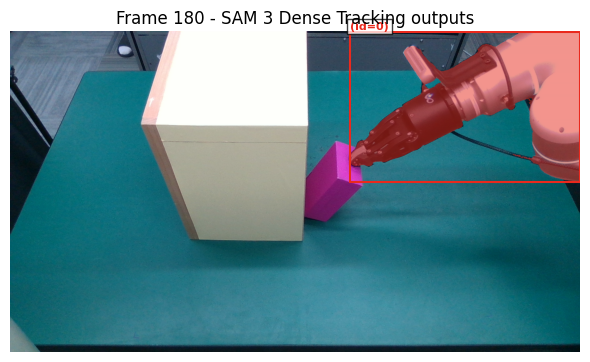

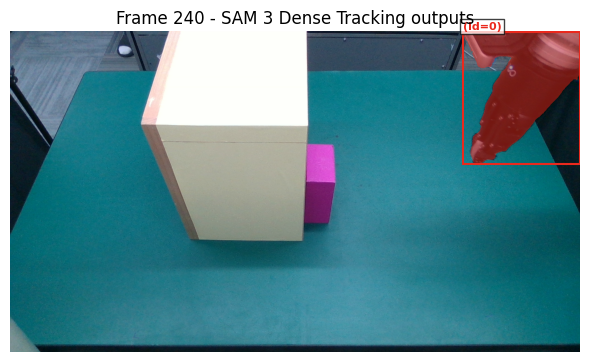

In [2]:
# response = predictor.handle_request(
#     request=dict(
#         type="remove_object",
#         session_id=session_id,
#         obj_id=1,
#     )
# )

# now we propagate the outputs from frame 0 to the end of the video and collect all outputs
outputs_per_frame = propagate_in_video(predictor, session_id)
print(len(outputs_per_frame))

# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)
# print(outputs_per_frame)

vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    visualize_formatted_frame_output(
        frame_idx,
        video_frames_for_vis,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

# sam3的逻辑是，要先跑一遍原始的视频处理，然后才能添加点

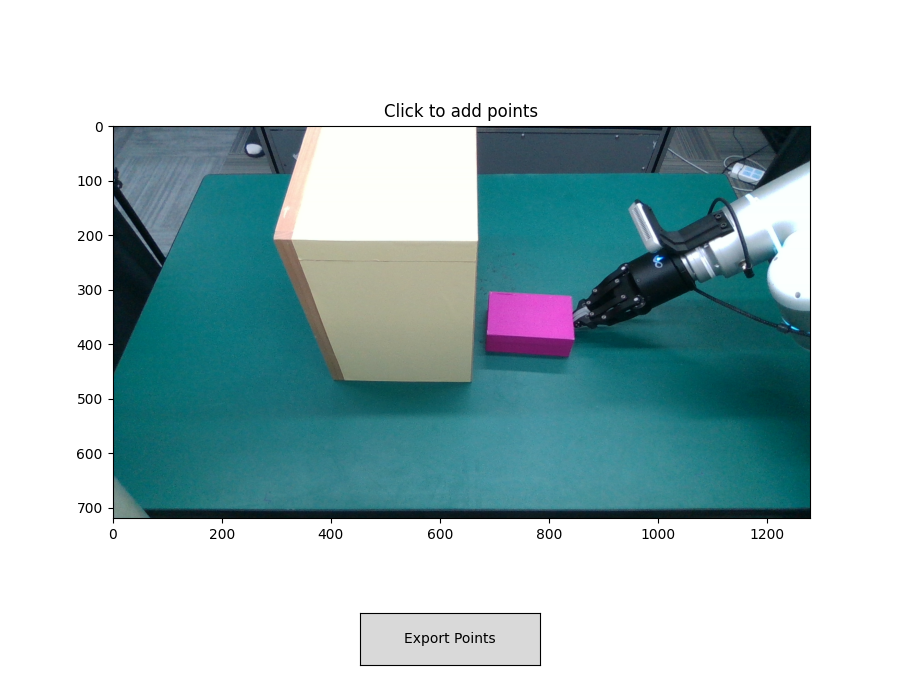

Output()

In [ ]:
# 启用 widget 后端
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Button
from PIL import Image
import ipywidgets as widgets # 导入控制输出的工具
from IPython.display import display

# 1. 创建一个专门的输出区域
out = widgets.Output()

# 选择第几帧标注
draw_frame_idx = 120

# 获取数据并转换 (这里假设你的环境已经有 load_frame 等函数)
frame_data = load_frame(video_frames_for_vis[draw_frame_idx])
if hasattr(frame_data, 'cpu'): frame_data = frame_data.cpu().numpy()
if frame_data.dtype == np.float32 or frame_data.dtype == np.float64:
    if frame_data.max() <= 1.05: frame_data = frame_data * 255.0
    frame_data = frame_data.astype(np.uint8)

sample_img = Image.fromarray(frame_data)

# 创建画布
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
plt.subplots_adjust(bottom=0.2) 
ax.imshow(sample_img)
ax.set_title("Click to add points")

coords = []

def onclick(event):
    if event.inaxes == ax:
        x, y = int(event.xdata), int(event.ydata)
        coords.append([x, y])
        ax.plot(x, y, 'r*', markersize=15)
        ax.text(x+10, y, f'({x},{y})', color='yellow', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        fig.canvas.draw()

# 修改后的打印逻辑
def export_points(event):
    with out: # 在指定的输出区域显示打印内容
        out.clear_output() # 每次点击清空之前的，防止刷屏
        print("# positive")
        for p in coords:
            print(f"        [{p[0]}, {p[1]}],")
        print("-" * 20) # 分割线

# 保持对按钮的引用，防止被垃圾回收
ax_btn = plt.axes([0.4, 0.05, 0.2, 0.075])
btn = Button(ax_btn, 'Export Points')
btn.on_clicked(export_points)

fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

# 2. 在最后显示这个输出区域
display(out)

In [5]:
# 基于标注，添加 positive 和 negative 点

IMG_WIDTH, IMG_HEIGHT = sample_img.size

# frame_idx = 120 # 要和标注帧匹配！
frame_idx = draw_frame_idx # 直接用上面的变量
obj_id = 2
points_abs = np.array(
    [
        [883, 332],
        [977, 174],
        [1017, 273],
        [1131, 334]
    ]
)
# positive clicks have label 1, while negative clicks have label 0
# labels = np.array([1, 0, 0, 1])
labels = np.array([1,1,1,1])

# convert points and labels to tensors; also convert to relative coordinates
points_tensor = torch.tensor(
    abs_to_rel_coords(points_abs, IMG_WIDTH, IMG_HEIGHT, coord_type="point"),
    dtype=torch.float32,
)
points_labels_tensor = torch.tensor(labels, dtype=torch.int32)

response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        points=points_tensor,
        point_labels=points_labels_tensor,
        obj_id=obj_id,
    )
)

  0%|          | 0/260 [00:00<?, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

100%|██████████| 260/260 [00:13<00:00, 19.30it/s]
0it [00:00, ?it/s]
100%|██████████| 260/260 [00:13<00:00, 19.30it/s]
0it [00:00, ?it/s]60/260 [00:13<00:00, 32.74it/s]
100%|██████████| 260/260 [00:13<00:00, 19.30it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]

260


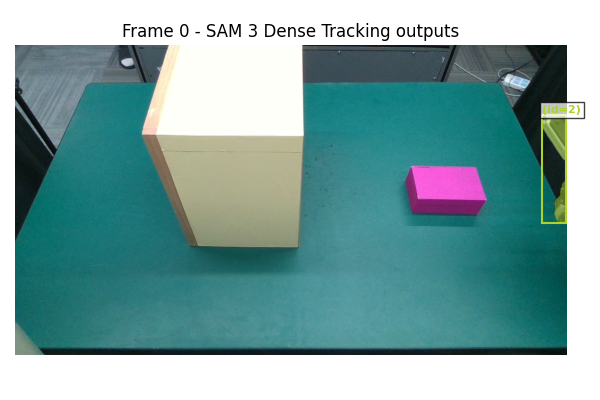

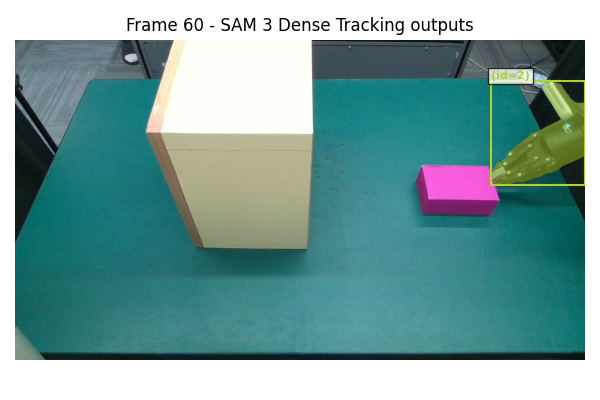

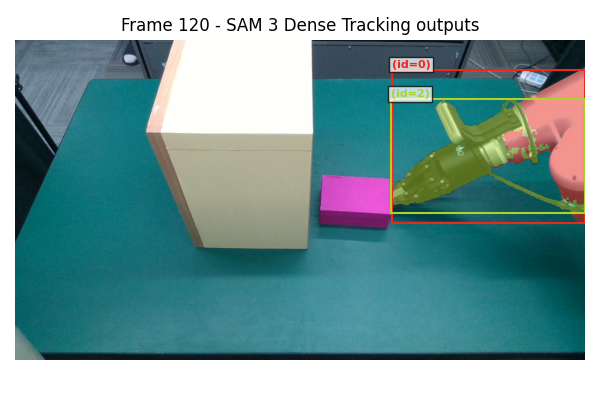

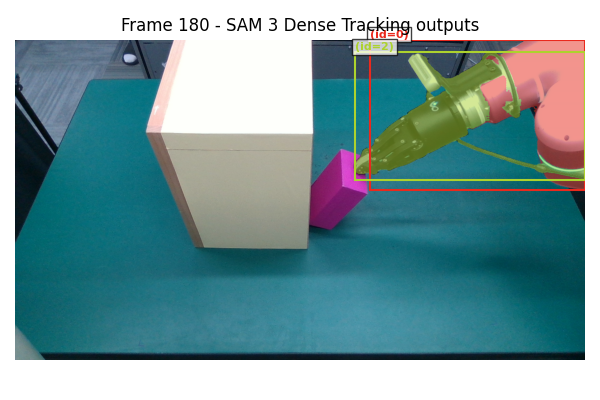

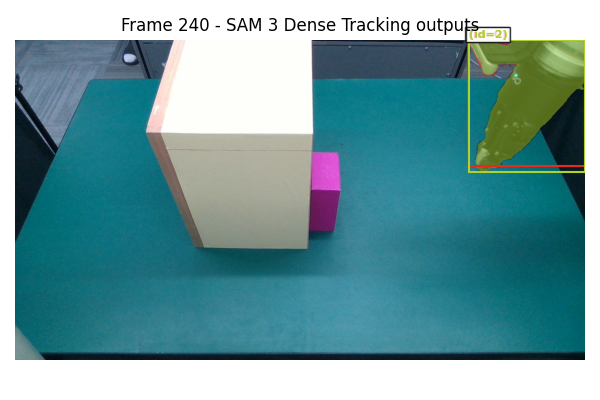

In [6]:
# response = predictor.handle_request(
#     request=dict(
#         type="remove_object",
#         session_id=session_id,
#         obj_id=1,
#     )
# )

# now we propagate the outputs from frame 0 to the end of the video and collect all outputs
outputs_per_frame = propagate_in_video(predictor, session_id)
print(len(outputs_per_frame))

# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)
# print(outputs_per_frame)

vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    visualize_formatted_frame_output(
        frame_idx,
        video_frames_for_vis,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

In [7]:
# 为 ProPainter 保存 mask 序列，并进行膨胀处理

def save_masks_for_propainter(outputs_per_frame, video_frames, output_dir="propainter_masks", 
                              dilate_radius=8):  # 新增参数：膨胀半径
    """
    为 ProPainter 生成 mask 序列，并进行膨胀处理。
    
    Args:
        outputs_per_frame: {frame_idx: {obj_id: binary_mask}} 
        video_frames: 视频帧路径列表或已加载的帧数组列表
        output_dir: 输出目录
        dilate_radius: 膨胀半径（像素）。值越大，Mask 扩得越粗。Mirage/ProPainter 一般建议 5-15 左右。
                       如果为 0 则不膨胀。
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # --- 1. 获取尺寸 ---
    first_frame = video_frames[0]
    if isinstance(first_frame, str):
        sample_img = Image.open(first_frame)
        img_width, img_height = sample_img.size
    else:
        if isinstance(first_frame, torch.Tensor):
            first_frame = first_frame.cpu().numpy()
        if first_frame.ndim == 4:
            first_frame = first_frame[0]
        img_height, img_width = first_frame.shape[0], first_frame.shape[1]
    
    print(f"视频尺寸: {img_width}x{img_height}, 共 {len(video_frames)} 帧")
    
    # --- 2. 准备膨胀 Kernel (核心修改部分) ---
    # Kernel 大小通常是 (2*radius + 1)，例如半径 5 对应 11x11 的核
    kernel = None
    if dilate_radius > 0:
        kernel_size = 2 * dilate_radius + 1
        # 创建矩形结构元素 (也可以用 cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ...) 创建圆形的)
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        print(f"启用 Mask 膨胀: 半径 {dilate_radius} (Kernel {kernel_size}x{kernel_size})")

    saved_paths = []
    
    for frame_idx in range(len(video_frames)):
        
        # --- 3. 生成基础 Mask ---
        # 初始化全黑图
        combined_mask = np.zeros((img_height, img_width), dtype=np.uint8)
        
        if frame_idx in outputs_per_frame and outputs_per_frame[frame_idx]:
            obj_dict = outputs_per_frame[frame_idx]
            
            for obj_id, mask in obj_dict.items():
                if isinstance(mask, torch.Tensor):
                    mask = mask.cpu().numpy()
                if mask.ndim > 2:
                    mask = mask.squeeze()
                
                # 合并 Mask
                binary_mask = (mask > 0).astype(np.uint8) * 255
                combined_mask = np.maximum(combined_mask, binary_mask)
        
        # --- 4. 执行膨胀 (核心修改部分) ---
        # 只有当 Mask 不是全黑时才膨胀
        if dilate_radius > 0 and np.any(combined_mask):
            # iterations=1 表示执行一次膨胀，配合 kernel 大小控制扩充程度
            combined_mask = cv2.dilate(combined_mask, kernel, iterations=1)

        # --- 5. 保存 ---
        filename = f"{frame_idx:05d}.png"
        filepath = os.path.join(output_dir, filename)
        Image.fromarray(combined_mask, mode='L').save(filepath)
        saved_paths.append(filepath)
        
        if frame_idx % 20 == 0:
            has_target = (frame_idx in outputs_per_frame and outputs_per_frame[frame_idx])
            status = "✓ 有目标" if has_target else "✗ 全黑"
            # print(f"处理帧 {frame_idx}/{len(video_frames)}: {status}")
    
    print(f"\n完成！已生成 {len(saved_paths)} 张 mask (膨胀半径={dilate_radius}) 至: {os.path.abspath(output_dir)}")
    return saved_paths

# --- 调用示例 ---
mask_paths = save_masks_for_propainter(
    outputs_per_frame=outputs_per_frame,
    video_frames=video_frames_for_vis,
    output_dir="/data/haoxiang/propainter/masks_FLIPPING_v3_scene0001",
    dilate_radius=10  # <--- 这里控制膨胀程度，一般 8-15 比较合适
)

视频尺寸: 1280x720, 共 260 帧
启用 Mask 膨胀: 半径 10 (Kernel 21x21)

完成！已生成 260 张 mask (膨胀半径=10) 至: /data/haoxiang/propainter/masks_FLIPPING_v3_scene0001


In [8]:
# finally, close the inference session to free its GPU resources
# (you may start a new session on another video)
_ = predictor.handle_request(
    request=dict(
        type="close_session",
        session_id=session_id,
    )
)

# after all inference is done, we can shutdown the predictor
# to free up the multi-GPU process group
predictor.shutdown()

INFO 2026-02-04 09:38:50,026 626674 sam3_video_predictor.py: 251: removed session 7fafbea9-eb22-4bfa-9c98-c003c2884359; live sessions: [], GPU memory: 5095 MiB used and 10888 MiB reserved (max over time: 10442 MiB used and 10888 MiB reserved)
INFO 2026-02-04 09:38:50,600 626489 sam3_video_predictor.py: 251: removed session 7fafbea9-eb22-4bfa-9c98-c003c2884359; live sessions: [], GPU memory: 5119 MiB used and 11582 MiB reserved (max over time: 10874 MiB used and 11582 MiB reserved)
INFO 2026-02-04 09:38:50,218 626675 sam3_video_predictor.py: 251: removed session 7fafbea9-eb22-4bfa-9c98-c003c2884359; live sessions: [], GPU memory: 5095 MiB used and 10908 MiB reserved (max over time: 10445 MiB used and 10908 MiB reserved)
INFO 2026-02-04 09:38:50,221 626673 sam3_video_predictor.py: 251: removed session 7fafbea9-eb22-4bfa-9c98-c003c2884359; live sessions: [], GPU memory: 5119 MiB used and 11340 MiB reserved (max over time: 10661 MiB used and 11340 MiB reserved)
INFO 2026-02-04 09:38:50,604